# Predicting Brain Pathology in Alzheimer's Disease using Elastic Net Regression

The notebook aims to check the data and prepare input for predictive models.

- Inputs:
    - Features (full_filled_year_dat_0303.txt): Clinical features include cognitive test scores, underlying health conditions, demographic.... 
    - Targets (pathology_dat_0303.txt): Pathology profiling includes amyloid, tangles, gpath, and NIA-Reagan scores.

- Outputs:
    - Prepare data from last visit for Elastic-Net
      - scaled_train_last.pkl, scaled_test_last.pkl
    - Prepare data from all visits for LSTM
      - NIAvalueUpdatedVersion_scaled_whole_decedents_dataset.pkl

# Analysis Steps
- Check Data
    - Correlation Analysis:
      - Identified 40 features with Pearson correlation coefficients > 0.4. Displayed results via a correlation heatmap.
- Data Preparation
    - Splitting data into 80% training and 20% testing sets.
    - Scaling features for model input.

# Set up

In [1]:
import utils
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import pandas as pd 
from sklearn.model_selection import train_test_split

In [2]:
# Optional: Verify the paths
print(f"Project Root: {utils.ROOT}")
print(f"Target Output Directory: {utils.RESULTS_DIR / 'S1' / 'S1.1'}")

Project Root: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version
Target Output Directory: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S1/S1.1


In [3]:
# Define the specific input directory using the anchor from utils
INPUT_DIR = utils.DATA_DIR / "raw"

# Define file paths safely
features_path = INPUT_DIR / "full_filled_year_dat_0303.txt"
targets_path  = INPUT_DIR / "pathology_dat_with_modifiedNIA_050425.txt"

features_path_DL = INPUT_DIR / "full_filled_year_dat_0725.txt"
targets_path_DL  = INPUT_DIR / "pathology_dat_with_modifiedNIA_0725.txt"

# Verification: Check if file exists
if not features_path_DL.exists():
    print(f"Error: File not found at {features_path_DL}")
else:
    print(f"Found input file: {features_path_DL.name}")

data_DL = utils.load_and_merge_data(features_path_DL, targets_path_DL, join_columns=['projid', 'study'])
unique_ids_DL = data_DL['projid'].unique()


Found input file: full_filled_year_dat_0725.txt


In [4]:
data_DL.shape

(280, 65)

In [5]:
# Split subjects into training and testing data
train_ids_DL, test_ids_DL = train_test_split(unique_ids_DL, test_size=0.2, random_state=1217)

# Split the original dataframe into training and testing sets
train_data_DL = data_DL[data_DL['projid'].isin(train_ids_DL)]
test_data_DL = data_DL[data_DL['projid'].isin(test_ids_DL)]

In [6]:
print('Training: ', len(train_ids_DL), 'Subject,', len(train_data_DL), 'Records') # Previous 1677 Subject, 16336 Records
print('Testing: ', len(test_ids_DL), 'Subject,', len(test_data_DL), 'Records') # Testing:  420 Subject, 4098 Records

Training:  224 Subject, 224 Records
Testing:  56 Subject, 56 Records


In [7]:
# # 读取文件，sep='\t' 表示制表符分隔
# livings_msex_data = pd.read_csv(
#     "Inputs/full_filled_year_dat_0303.txt",
#     sep="\t",           # 制表符分隔
#     index_col=0         # 把第一列当成索引，自动丢掉它
# )

# print(livings_msex_data.head())

# # Python
# livings_msex_data.to_csv("Outputs/livings_msex_data.csv", index=False, encoding="utf-8")

# 1. Check Data 

In [8]:
# Load data
data = utils.load_and_merge_data(features_path, targets_path, join_columns=['projid', 'study'])

In [9]:
data.shape

(114, 65)

In [10]:
data.columns

Index(['projid', 'fu_year', 'study', 'cogdx', 'age_at_visit', 'bmi',
       'cogn_global', 'cts_mmse30', 'dbp_avg', 'sbp_avg', 'phys5itemsum',
       'cesdsum', 'soc_net', 'hypertension_cum', 'cancer_cum', 'dm_cum',
       'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum',
       'stroke_cum', 'vasc_risks_sum', 'mental_health_rx', 'analgesic_rx',
       'antibiotic_rx', 'antihyp_all_rx', 'cardiac_rx', 'antianxiety_rx',
       'anti_inflammatory_rx', 'aspirin_rx', 'lipid_lowering_rx',
       'insomnia_rx', 'diabetes_rx', 'educ', 'msex', 'mateduc', 'pateduc',
       'extraversion_6', 'anxiety_10items', 'early_hh_ses', 'neuroticism_12',
       'angertrait', 'alcohol_g_bl', 'ldai_bl', 'smoking', 'apoe_E2',
       'apoe_E4', 'TOMM40_S', 'TOMM40_L', 'TOMM40_VL', 'motor_dexterity',
       'motor_gait', 'motor_handstreng', 'bradysc', 'gaitsc', 'rigidsc',
       'tremsc', 'q1slp', 'q2slp', 'q4slp', 'q5slp', 'gpath', 'tangles',
       'amyloid', 'niareagansc'],
      dtype='objec

In [11]:
# number of subjects
unique_ids = data['projid'].unique()
len(unique_ids)

114

In [12]:
print(data['niareagansc'].describe())

count    114.000000
mean       4.964912
std        2.768118
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max        9.000000
Name: niareagansc, dtype: float64


## 1.1 Check correlation between features

In [13]:
exclude_columns = ['study', 'projid', 'fu_year', 'cogdx']
correlation_matrix = data.drop(exclude_columns, axis=1).corr()

# Create the initial mask for the upper triangle and values below 0.4
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) | (correlation_matrix.abs() < 0.4)

# Identify rows and columns that are fully masked
keep_rows = ~np.all(mask, axis=1)  # Rows to keep
keep_cols = ~np.all(mask, axis=0)  # Columns to keep

filtered_corr = correlation_matrix.loc[keep_rows, keep_cols]
filtered_mask = mask.loc[keep_rows, keep_cols]


- 40 features have correlation coefficent > 0.4 with at least one feature 

In [14]:
combined_list = filtered_corr.index.to_list() + filtered_corr.columns.to_list()
len(set(combined_list))

2

- correlation heatmap

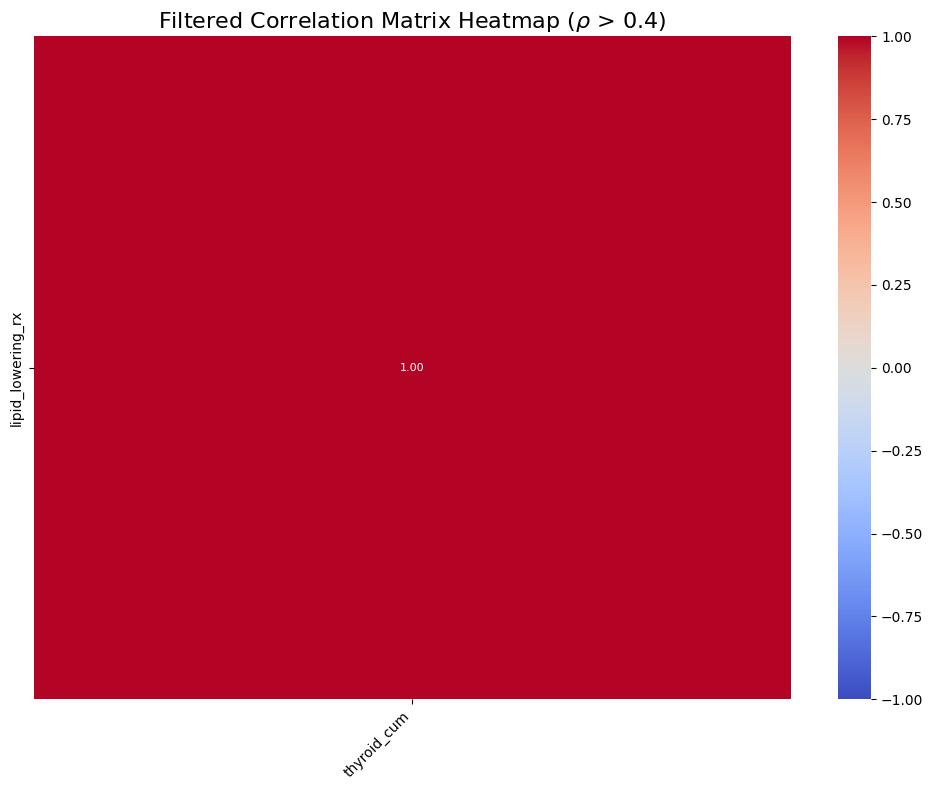

In [15]:
# Filter the correlation matrix to include only rows and columns that are not fully masked
# Set up the figure size
plt.figure(figsize=(10, 8))

# Create the heatmap with the filtered correlation matrix and mask
sns.heatmap(
    filtered_corr,
    mask=filtered_mask,
    annot=filtered_corr[filtered_corr.abs() > 0.4],  # Annotate only values > 0.4
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt='.2f',  # Format for annotations
    annot_kws={"size": 8},  # Annotation font size
    xticklabels=True,
    yticklabels=True,
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add a title to the heatmap
plt.title(r"Filtered Correlation Matrix Heatmap ($\rho$ > 0.4)", fontsize=16)

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show the heatmap
plt.show()

## 1.2 Split data into training and testing

In [16]:
# Split subjects into training and testing data
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Split the original dataframe into training and testing sets
train_data = data[data['projid'].isin(train_ids)]
test_data = data[data['projid'].isin(test_ids)]

In [17]:
print('Training: ', len(train_ids), 'Subject,', len(train_data), 'Records')
print('Testing: ', len(test_ids), 'Subject,', len(test_data), 'Records')

Training:  91 Subject, 91 Records
Testing:  23 Subject, 23 Records


## 2. Prepare data from last visit for Elastic-Net

## 2.1 Get the last visit for training and testing datasets

In [18]:
train_last = utils.get_last_visit(train_data, ['fu_year'], 'projid')
test_last = utils.get_last_visit(test_data, ['fu_year'], 'projid')

## 2.2 Scale data

In [19]:
# Columns to scale
exclude_columns = ['study', 'projid', 'fu_year', 'cogdx' ]
columns_to_scale = [col for col in train_last.columns if col not in exclude_columns]

# Scale the last visit (training)
scaled_train_last, scalers = utils.transform_data(data=train_last, columns=columns_to_scale,
                                              transformer_type='StandardScaler', fit=True)
# Scale the last visit of testing using the same scalers
scaled_test_last = utils.transform_data(data=test_last, columns=columns_to_scale, 
                                    transformers=scalers, fit=False)

In [20]:
# Target: results/S1/S1.1
OUTPUT_DIR = utils.RESULTS_DIR / "S1" / "S1.1"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True) 

print(f"Saving files to: {OUTPUT_DIR}")
scaled_train_last.to_pickle(OUTPUT_DIR / "NIAvalueUpdatedVersion_scaled_train_last.pkl")
scaled_test_last.to_pickle(OUTPUT_DIR / "NIAvalueUpdatedVersion_scaled_test_last.pkl")

Saving files to: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S1/S1.1


## 3. Prepare input tensor data for LSTM

In [21]:
# Define columns to scale (excluding 'study', 'projid', 'fu_year', 'cogdx')
columns_to_scale = train_data.drop(columns=['study', 'projid', 'fu_year', 'cogdx']).columns

# Transform 100% decedents data (fit and scale)
scaled_whole_decedents_dataset, scalers = utils.transform_data(
    data=data,
    columns=columns_to_scale,
    transformer_type="MinMaxScaler",
    fit=True,  # Fit new scalers
)

# Transform livings data (use pre-fitted scalers)
scaled_train_DL = utils.transform_data(
    data=train_data_DL,
    columns=columns_to_scale,
    transformer_type="MinMaxScaler",
    transformers=scalers,  # Use pre-fitted scalers
    fit=False,  # Do not fit new scalers
)

# Transform livings data (use pre-fitted scalers)
scaled_test_DL = utils.transform_data(
    data=test_data_DL,
    columns=columns_to_scale,
    transformer_type="MinMaxScaler",
    transformers=scalers,  # Use pre-fitted scalers
    fit=False,  # Do not fit new scalers
)

In [22]:
print(f"Shape for the scale train_DL is {scaled_train_DL.shape}")
print(f"Shape for the scale test_DL is {scaled_test_DL.shape}")

Shape for the scale train_DL is (224, 65)
Shape for the scale test_DL is (56, 65)


In [23]:
# --- 2. Save Pickle Files ---
scaled_train_DL.to_pickle(OUTPUT_DIR / "scaled_train_with_modifiedNIA_0725.pkl")
scaled_test_DL.to_pickle(OUTPUT_DIR / "scaled_test_with_modifiedNIA_0725.pkl")

# --- 3. Save CSV Files ---
scaled_train_DL.to_csv(OUTPUT_DIR / "scaled_train_with_modifiedNIA_0725.csv", index=False)
scaled_test_DL.to_csv(OUTPUT_DIR / "scaled_test_with_modifiedNIA_0725.csv", index=False)

# --- 4. Save Whole Decedents Data (Cell 27) ---
scaled_whole_decedents_dataset.to_pickle(OUTPUT_DIR / "NIAvalueUpdatedVersion_scaled_whole_decedents_dataset.pkl")
scaled_whole_decedents_dataset.to_csv(OUTPUT_DIR / "NIAvalueUpdatedVersion_scaled_whole_decedents_dataset.csv", index=False)

print("All files saved successfully.")

All files saved successfully.


In [24]:
print(f"The unique number of projid in scaled_whole_decedents_dataset is {scaled_whole_decedents_dataset['projid'].nunique()}")

The unique number of projid in scaled_whole_decedents_dataset is 114
